<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/Investigate%20on%20the%20model%20with%20KDDCup99%20dataset%20(08112023).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hybrid RF-LSTM for 4 class classifications based on WSNBFSF dataset ver.2.2**

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#from keras.utils import np_utils
from tensorflow.python.keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [3]:
# Load dataset
dataset = pd.read_csv("dataset_KDDCup99.csv")
dataset.isnull().sum()

duration                       0
protocol_type_label            0
service_label                  0
flag_label                     0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
lnum_compromised               0
lroot_shell                    0
lsu_attempted                  0
lnum_root                      0
lnum_file_creations            0
lnum_shells                    0
lnum_access_files              0
lnum_outbound_cmds             0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494020 non-null  int64  
 1   protocol_type_label          494020 non-null  int64  
 2   service_label                494020 non-null  int64  
 3   flag_label                   494020 non-null  int64  
 4   src_bytes                    494020 non-null  int64  
 5   dst_bytes                    494020 non-null  int64  
 6   land                         494020 non-null  int64  
 7   wrong_fragment               494020 non-null  int64  
 8   urgent                       494020 non-null  int64  
 9   hot                          494020 non-null  int64  
 10  num_failed_logins            494020 non-null  int64  
 11  logged_in                    494020 non-null  int64  
 12  lnum_compromised             494020 non-null  int64  
 13 

In [10]:
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['Class'])
y = np_utils.to_categorical(y, num_classes=23)  # update to 23 classes
X = dataset.drop(['Class'], axis=1)
X = X.values
print(X.shape)
print(y.shape)

(494020, 41)
(494020, 23)


In [11]:
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['Class'])
num_classes = len(encoder.classes_)
X = dataset.drop(['Class'], axis=1)
X = X.values

In [12]:
import collections as c
counter = c.Counter(y)
print(counter)

Counter({18: 280790, 10: 107201, 0: 97277, 2: 2203, 17: 1589, 6: 1247, 15: 1040, 21: 1020, 20: 979, 14: 264, 11: 231, 4: 53, 1: 30, 7: 21, 22: 20, 5: 12, 16: 10, 8: 9, 3: 8, 9: 7, 13: 4, 12: 3, 19: 2})


**Data Preprocessing**

In [ ]:
# Data preprocessing
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [13]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
X, y = oversample.fit_resample(X, y)
counter = c.Counter(y)
print(counter)

Counter({0: 280790, 1: 280790, 8: 280790, 12: 280790, 10: 280790, 18: 280790, 4: 280790, 14: 280790, 20: 280790, 15: 280790, 6: 280790, 7: 280790, 3: 280790, 2: 280790, 5: 280790, 17: 280790, 13: 280790, 11: 280790, 9: 280790, 22: 280790, 21: 280790, 19: 280790, 16: 280790})


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

**Hybrid RF-LSTM for 4 class Ver.2.2**

In [16]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.regularizers import l2
import numpy as np

# Train RF model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

# Extract features from RF model
train_rf_features = rf_model.predict(X_train)
test_rf_features = rf_model.predict(X_test)

# Reshape RF features for LSTM input
train_rf_features = np.reshape(train_rf_features, (train_rf_features.shape[0], 1, 1))
test_rf_features = np.reshape(test_rf_features, (test_rf_features.shape[0], 1, 1))

In [20]:
from keras.utils import to_categorical
# Build the LSTM model with the correct output shape
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, train_rf_features.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001)))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(16, kernel_regularizer=l2(0.001)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(num_classes, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_train = to_categorical(y_train, num_classes=num_classes)  # One-hot encode y_train

history = lstm_model.fit(train_rf_features, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the hybrid model on the test set
test_lstm_features = lstm_model.predict(test_rf_features)
test_rf_lstm_predictions = np.argmax(test_lstm_features, axis=1)

Epoch 1/50
64582/64582 [==============================] - 309s 5ms/step - loss: 1.3458 - accuracy: 0.4676 - val_loss: 0.6276 - val_accuracy: 0.9130
Epoch 2/50
64582/64582 [==============================] - 293s 5ms/step - loss: 1.0511 - accuracy: 0.5789 - val_loss: 0.4808 - val_accuracy: 1.0000
Epoch 3/50
64582/64582 [==============================] - 290s 4ms/step - loss: 0.9975 - accuracy: 0.5990 - val_loss: 0.4542 - val_accuracy: 1.0000
Epoch 4/50
64582/64582 [==============================] - 306s 5ms/step - loss: 0.9787 - accuracy: 0.6042 - val_loss: 0.4517 - val_accuracy: 1.0000
Epoch 5/50
64582/64582 [==============================] - 300s 5ms/step - loss: 0.9676 - accuracy: 0.6074 - val_loss: 0.4401 - val_accuracy: 0.9565
Epoch 6/50
64582/64582 [==============================] - 301s 5ms/step - loss: 0.9597 - accuracy: 0.6109 - val_loss: 0.4451 - val_accuracy: 0.9565
Epoch 7/50
64582/64582 [==============================] - 288s 4ms/step - loss: 0.9534 - accuracy: 0.6145 - val_

In [32]:
# Evaluate the hybrid model on the test set
test_lstm_features = lstm_model.predict(test_rf_features)
test_rf_lstm_predictions = np.argmax(test_lstm_features, axis=1)

# Convert y_test to one-hot encoding
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

print(confusion_matrix(np.argmax(y_test_encoded, axis=1), test_rf_lstm_predictions))
print(classification_report(np.argmax(y_test_encoded, axis=1), test_rf_lstm_predictions))

40364/40364 [==============================] - 66s 2ms/step
[[56442     0     0     0     0     0     0     0     0     0     0     0
      0     0     1     0     0     1     0     0     0     0     0]
 [56295     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0 56168     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0 56381     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0 56085     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0 56864     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0 55774     0     0     0     0     0
      0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67     56444
           1       0.00      0.00      0.00     56295
           2       1.00      1.00      1.00     56168
           3       1.00      1.00      1.00     56381
           4       1.00      1.00      1.00     56085
           5       1.00      1.00      1.00     56864
           6       1.00      1.00      1.00     55812
           7       1.00      1.00      1.00     56525
           8       1.00      1.00      1.00     56083
           9       1.00      1.00      1.00     55810
          10       1.00      1.00      1.00     56101
          11       1.00      1.00      1.00     56420
          12       1.00      1.00      1.00     56063
          13       1.00      1.00      1.00     56518
          14       1.00      1.00      1.00     55990
          15       1.00      1.00      1.00     56072
          16       1.00      1.00      1.00     55860
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


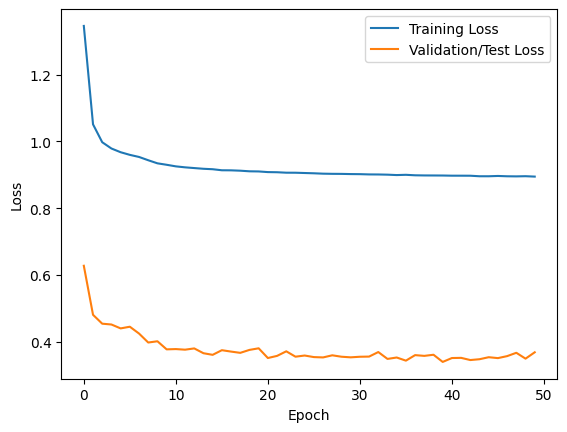

In [33]:
# Plot training/validation loss over each epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test_encoded, axis=1), test_rf_lstm_predictions)
recall = recall_score(np.argmax(y_test_encoded, axis=1), test_rf_lstm_predictions, average='weighted')
precision = precision_score(np.argmax(y_test_encoded, axis=1), test_rf_lstm_predictions, average='weighted')
f1score = f1_score(np.argmax(y_test_encoded, axis=1), test_rf_lstm_predictions, average='weighted')
confusion_mat = confusion_matrix(np.argmax(y_test_encoded, axis=1), test_rf_lstm_predictions)
classification_rep = classification_report(np.argmax(y_test_encoded, axis=1),, test_rf_lstm_predictions)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1score)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", classification_rep)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9563847034066926
Recall: 0.9563847034066926
Precision: 0.9345633708882358
F1-Score: 0.941843884792115
Confusion Matrix:
 [[56442     0     0     0     0     0     0     0     0     0     0     0
      0     0     1     0     0     1     0     0     0     0     0]
 [56295     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0 56168     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0 56381     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0 56085     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0 56864     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


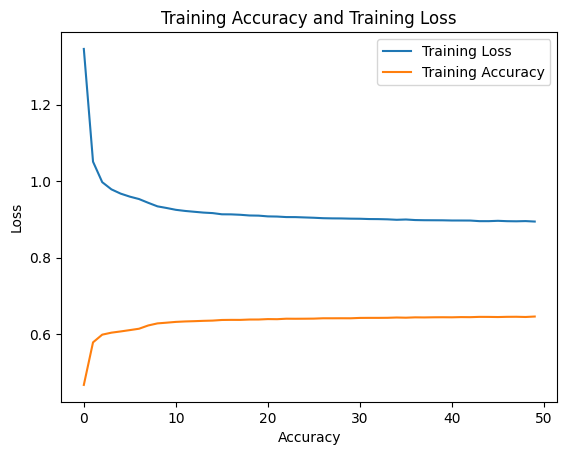

In [38]:
# Plot training loss and validation/test loss over each epoch of training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy and Training Loss')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()

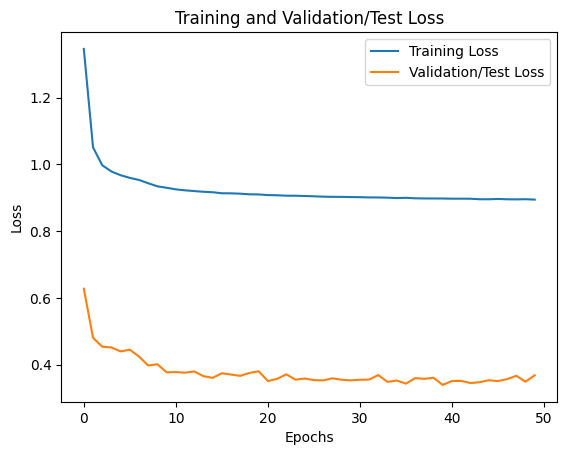

In [39]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.title('Training and Validation/Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  plt.figure(figsize=(6,5.5))
  ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='copper')
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ax.yaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


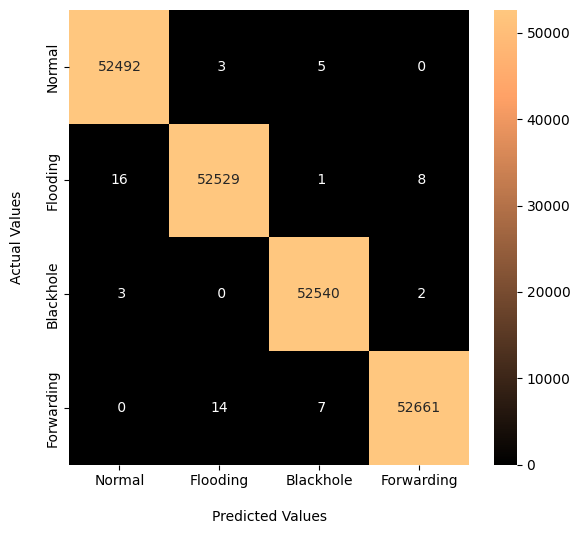

In [ ]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)

In [ ]:
report = classification_report(np.argmax(y_test, axis=1), test_rf_lstm_predictions, output_dict=True)
detection_rates = {}
for cls in range(4):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']
print("Detection rates of Hybrid RF-LSTM Model:", detection_rates)

Detection rates of Hybrid RF-LSTM Model: {0: 0.9998476190476191, 1: 0.9995242988164554, 2: 0.9999048434675041, 3: 0.9996013818761627}


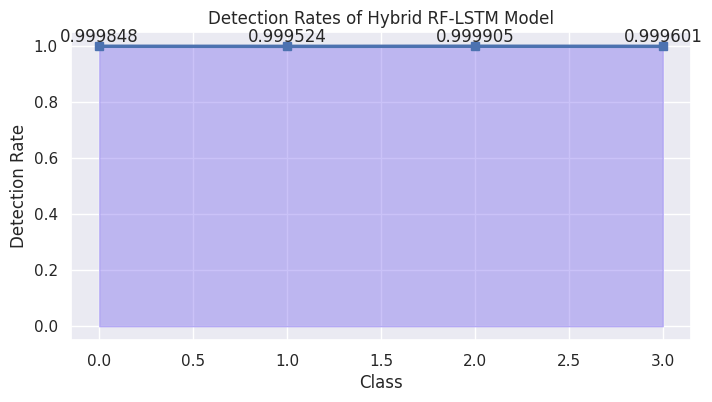

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

report = classification_report(np.argmax(y_test, axis=1), test_rf_lstm_predictions, output_dict=True)
detection_rates = {}
for cls in range(4):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']

# Extract the class labels and detection rates
labels = list(detection_rates.keys())
rates = list(detection_rates.values())

# Plot the line graph with filled area and labels
plt.figure(figsize=(8, 4))
plt.plot(labels, rates, marker='s', linestyle='-', linewidth=2.5)
plt.fill_between(labels, rates, color='mediumslateblue', alpha=0.4)

# Add labels to each data point
for i in range(len(labels)):
    plt.text(labels[i], rates[i], "{:.6f}".format(rates[i]), ha='center', va='bottom')

plt.xlabel('Class')
plt.ylabel('Detection Rate')
plt.title('Detection Rates of Hybrid RF-LSTM Model')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

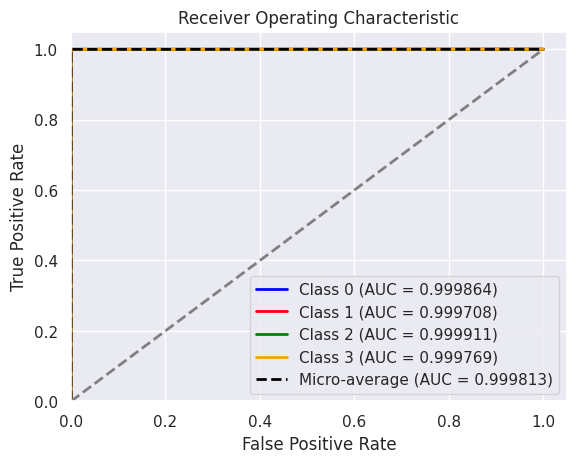

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from keras.utils import np_utils

# Convert y_test and test_rf_lstm_predictions to one-hot encoded format
y_test_onehot = np_utils.to_categorical(np.argmax(y_test, axis=1))
test_rf_lstm_predictions_onehot = np_utils.to_categorical(test_rf_lstm_predictions, num_classes=4)  # Convert to one-hot encoded format with 4 classes

# Compute the AUC and ROC curves for each class
n_classes = y_test_onehot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], test_rf_lstm_predictions_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), test_rf_lstm_predictions_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure()
colors = ['blue', 'red', 'green', 'orange']  # Adjust the colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.6f})'.format(i, roc_auc[i]))

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=2, linestyle='--', label='Micro-average (AUC = {0:0.6f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print confusion matrix and classification report
##print(confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(test_rf_features_onehot, axis=1)))
##print(classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(test_rf_features_onehot, axis=1)))

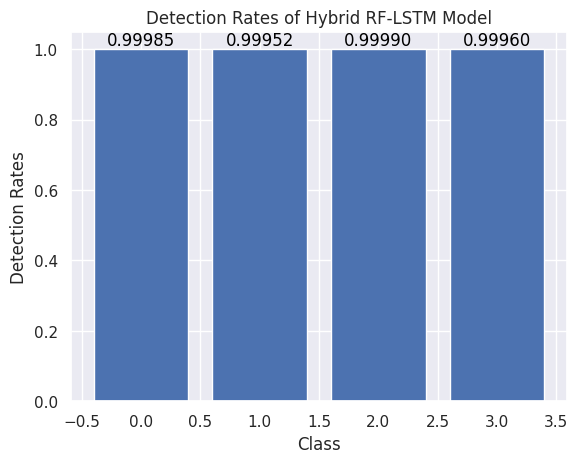

In [ ]:
import matplotlib.pyplot as plt

# Extract the labels and rates from the detection rates dictionary
labels = list(detection_rates.keys())
rates = list(detection_rates.values())

# Plot the bar chart
plt.bar(labels, rates)

# Add labels and units to each bar
for i in range(len(labels)):
    plt.text(labels[i], rates[i], "{:.5f}".format(rates[i]), ha='center', va='bottom', color='black')

# Add axis labels and title
plt.xlabel('Class')
plt.ylabel('Detection Rates')
plt.title('Detection Rates of Hybrid RF-LSTM Model')

# Display the plot
plt.show()